In [1]:
from timeseries_ml_utils.data import *
from timeseries_ml_utils.statistics import *
from scipy.fftpack import dct, idct
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, GRU, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.utils import plot_model
from keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt
import re

Using TensorFlow backend.


In [2]:
# fetch data
data = DataFetcher(["GLD.US"], limit=450)
data.fetch_data().tail()


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-11-15,114.83,114.99,114.56,114.77,8910585
2018-11-16,115.83,115.88,115.37,115.62,8576955
2018-11-19,115.45,115.92,115.37,115.67,8508445
2018-11-20,115.94,115.95,115.37,115.67,9075193
2018-11-21,115.94,116.35,115.86,115.86,8834206


In [3]:
print(len(data.get_dataframe()))
model_data = DataGenerator(data.get_dataframe(), {"^trigonometric": False, "(Open|High|Low|Close)$": True}, {"GLD.US.Close$": True},
                           aggregation_window_size=16)
print(model_data.batch_feature_shape)
print(model_data.batch_label_shape)
model_data.features, model_data.labels


450


(100, 260, 224)
(100, 16)


([('GLD.US.Open', True),
  ('GLD.US.High', True),
  ('GLD.US.Low', True),
  ('GLD.US.Close', True),
  ('trigonometric_time.cos_dow', False),
  ('trigonometric_time.sin_dow', False),
  ('trigonometric_time.cos_woy', False),
  ('trigonometric_time.sin_woy', False),
  ('trigonometric_time.cos_doy', False),
  ('trigonometric_time.sin_doy', False),
  ('trigonometric_time.sin_yer', False),
  ('trigonometric_time.cos_yer', False),
  ('trigonometric_time.sin_dec', False),
  ('trigonometric_time.cos_dec', False)],
 [('GLD.US.Close', True)])

In [5]:
model = Sequential(name="LSTM-Model-1")
model.add(LSTM(model_data.batch_label_shape[-1],
               name="LSTM-Layer-1",
               batch_input_shape=model_data.batch_feature_shape,
               activation='tanh',
               dropout=0,
               recurrent_dropout=0,
               stateful=True,
               return_sequences=model_data.return_sequences))

model.compile("Adam", loss="mse")
print(model.layers[0].get_weights()[0][0])
model.save("/tmp/keras-foo-1.h5")

[-0.07901971 -0.11558106  0.13578272  0.01772285  0.13995275  0.07036273
 -0.13751999  0.01572911 -0.13787395  0.07176749 -0.04109819 -0.14379832
 -0.13448665  0.03463097 -0.00539544 -0.0279146   0.1076571  -0.03642374
 -0.02730756  0.1435211  -0.06979103 -0.00711511 -0.00039981  0.09695151
 -0.05436311  0.07307047 -0.00443029  0.04976869  0.13558656 -0.01284525
  0.03936031 -0.13817513  0.02174966 -0.01313752 -0.1027153   0.02772495
 -0.06495997  0.07997178 -0.02942952 -0.07496925  0.08708726 -0.09885976
 -0.1308433  -0.03728925 -0.13820966  0.02022296 -0.03148213 -0.03998494
  0.10131106 -0.12266087 -0.12934674  0.07216626  0.076553   -0.09176829
  0.00754139  0.05097145 -0.12644468 -0.04121086 -0.04246135  0.00667261
 -0.1353322   0.02897248  0.01127675 -0.10202523]


Epoch 1/1


 1/48 [..............................] - ETA: 3:04 - loss: 0.1146

 2/48 [>.............................] - ETA: 1:42 - loss: 0.1051

 3/48 [>.............................] - ETA: 1:17 - loss: 0.0949

 4/48 [=>............................] - ETA: 1:05 - loss: 0.0859

 5/48 [==>...........................] - ETA: 54s - loss: 0.0779 

 6/48 [==>...........................] - ETA: 47s - loss: 0.0707

 7/48 [===>..........................] - ETA: 43s - loss: 0.0645

 8/48 [====>.........................] - ETA: 39s - loss: 0.0589

 9/48 [====>.........................] - ETA: 36s - loss: 0.0541

10/48 [=====>........................] - ETA: 33s - loss: 0.0499

11/48 [=====>........................] - ETA: 31s - loss: 0.0462

/home/kic/sources/github/python/timeseries_ml_utils/timeseries_ml_utils/statistics.py:12: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  prediction_distance = fastdtw(x1, y1)[0]



 [0.80848482 0.82515876 0.8418327  0.85850664 0.87518059 0.89185453
 0.90852847 0.92520241 0.94187636 0.9585503  0.97522424] 



12/48 [======>.......................] - ETA: 33s - loss: 0.0431

13/48 [=======>......................] - ETA: 31s - loss: 0.0403

14/48 [=======>......................] - ETA: 28s - loss: 0.0379

15/48 [========>.....................] - ETA: 27s - loss: 0.0357

16/48 [=========>....................] - ETA: 25s - loss: 0.0338

17/48 [=========>....................] - ETA: 23s - loss: 0.0321

18/48 [==========>...................] - ETA: 22s - loss: 0.0306

19/48 [==========>...................] - ETA: 21s - loss: 0.0292

20/48 [===========>..................] - ETA: 20s - loss: 0.0279

21/48 [============>.................] - ETA: 18s - loss: 0.0267


 [0.84354371 0.85797118 0.87239865 0.88682612 0.90125358 0.91568105
 0.93010852 0.94453599 0.95896346 0.97339092 0.98781839] 



22/48 [============>.................] - ETA: 18s - loss: 0.0256

23/48 [=============>................] - ETA: 17s - loss: 0.0246

24/48 [==============>...............] - ETA: 16s - loss: 0.0237

25/48 [==============>...............] - ETA: 15s - loss: 0.0228

26/48 [===============>..............] - ETA: 14s - loss: 0.0221

27/48 [===============>..............] - ETA: 14s - loss: 0.0213

28/48 [================>.............] - ETA: 13s - loss: 0.0206

29/48 [=================>............] - ETA: 12s - loss: 0.0200

30/48 [=================>............] - ETA: 11s - loss: 0.0194

31/48 [==================>...........] - ETA: 10s - loss: 0.0188


 [0.87057586 0.88247685 0.89437784 0.90627882 0.91817981 0.9300808
 0.94198178 0.95388277 0.96578376 0.97768474 0.98958573] 



32/48 [===================>..........] - ETA: 10s - loss: 0.0183

33/48 [===================>..........] - ETA: 9s - loss: 0.0178 

34/48 [====================>.........] - ETA: 8s - loss: 0.0173

35/48 [====================>.........] - ETA: 8s - loss: 0.0168

36/48 [=====================>........] - ETA: 7s - loss: 0.0164

37/48 [======================>.......] - ETA: 6s - loss: 0.0160

38/48 [======================>.......] - ETA: 5s - loss: 0.0156

39/48 [=======================>......] - ETA: 5s - loss: 0.0152

40/48 [========================>.....] - ETA: 4s - loss: 0.0149

41/48 [========================>.....] - ETA: 3s - loss: 0.0146


 [0.89944795 0.90871868 0.91798941 0.92726014 0.93653087 0.9458016
 0.95507234 0.96434307 0.9736138  0.98288453 0.99215526] 



42/48 [=========================>....] - ETA: 3s - loss: 0.0142

43/48 [=========================>....] - ETA: 2s - loss: 0.0139

44/48 [==========================>...] - ETA: 2s - loss: 0.0137

45/48 [===========================>..] - ETA: 1s - loss: 0.0134

46/48 [===========================>..] - ETA: 1s - loss: 0.0131

47/48 [============================>.] - ETA: 0s - loss: 0.0129

48/48 [==============================] - 30s 633ms/step - loss: 0.0126 - val_loss: 0.0021



 [0.93248913 0.93847438 0.94445962 0.95044487 0.95643012 0.96241536
 0.96840061 0.97438586 0.9803711  0.98635635 0.9923416 ] 



Tested 1 samples
0.9325    | #
0.9385    | ##
0.9445    | #####
0.9504    | #
0.9564    | #####
0.9624    | ####
0.9684    | #####
0.9744    | ###############
0.9804    | ##################################################
0.9864    | ###############################################


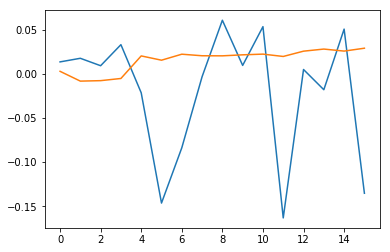

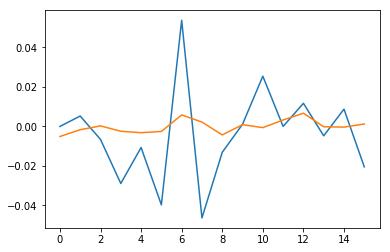

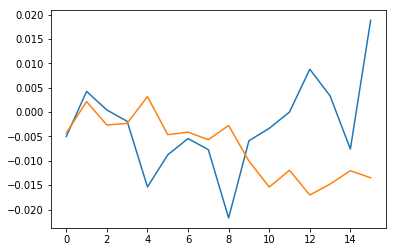

In [4]:

model = load_model("/tmp/keras-foo-1.h5")


#tensorboard = TensorBoard(log_dir="./.logs{}".format("-a"), histogram_freq=0, batch_size=1, 
#                          write_grads=True, write_images=True, update_freq="batch")

train_data = model_data
test_data = model_data.as_test_data_generator(model)
callback = test_data.get_keras_callback(frequency=10)

hist = model.fit_generator(generator=train_data,
                           validation_data=test_data,
                           epochs=1,
                           use_multiprocessing=True,
                           workers=4,
                           shuffle=False,
                           callbacks=[callback])


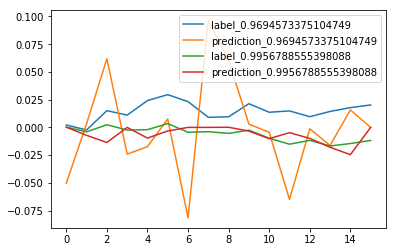